# OHBM 2022 abstract

In [1]:
import tarfile
import io
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from fmriprep_denoise.metrics import partial_correlation


# Load metric data
path_root = Path.cwd().parents[0] / "inputs"
file_qcfc = "dataset-ds000288_atlas-schaefer7networks_nroi-400_desc-qcfc.tsv"
file_dist = "atlas/schaefer7networks/atlas-schaefer7networks_nroi-400_desc-distance.tsv"
file_network = "dataset-ds000288_atlas-schaefer7networks_nroi-400_desc-modularity.tsv"
file_dataset = "dataset-ds000288.tar.gz"

with tarfile.open(path_root / file_dataset, 'r:gz') as tar:
    movement = tar.extractfile(
        "dataset-ds000288/dataset-ds000288_desc-movement_phenotype.tsv").read()
    movement = pd.read_csv(io.BytesIO(movement),
                        sep='\t', index_col=0, header=0, encoding='utf8')
    movement = movement.sort_index()


pairwise_distance = pd.read_csv(path_root / file_dist, sep='\t')
qcfc = pd.read_csv(path_root / file_qcfc, sep='\t', index_col=0)
modularity = pd.read_csv(path_root / file_network, sep='\t', index_col=0)

sig_per_edge = qcfc.filter(regex="pvalue")
sig_per_edge.columns = [col.split('_')[0] for col in sig_per_edge.columns]
metric_per_edge = qcfc.filter(regex="correlation")
metric_per_edge.columns = [col.split('_')[0] for col in metric_per_edge.columns]

long_qcfc = metric_per_edge.melt()
long_qcfc.columns = ["Strategy", "qcfc"]
long_qcfc["row"] = np.hstack((np.ones(int(long_qcfc.shape[0] / 3)), 
                              np.ones(int(long_qcfc.shape[0] / 3))* 2,
                              np.ones(int(long_qcfc.shape[0] / 3))* 3)
                             )
long_qcfc["col"] = np.tile(np.hstack((np.ones(metric_per_edge.shape[0]) * i for i in range(3))), 3)

/tmp/ipykernel_10667/16573514.py:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  long_qcfc["col"] = np.tile(np.hstack((np.ones(metric_per_edge.shape[0]) * i for i in range(3))), 3)


## Impact of confound removal strategies on functional connectivity generated from fMRIprep preprocessed data


H-T Wang[^1], P Bellec[^1][^2]

[^1]: CRIUGM - Université de Montréal, Montréal, QC, Canada
[^2]: Université de Montréal, Montréal, QC, Canada


### Introduction

Denoising strategy is an important topic in fMRI data analysis. 
The impact of the choice of confound regressor on functional connectivity has been a key debates in the field of fMRI (cf. global signal regression). 
Recent minimal preprocessing pipeline, fMRIPrep {cite:p}`esteban_fmriprep_2020`, aims to reduce the degree of freedom during the preprocessing step. 
However, a wide range of confound regressors can still introduce errors by the users.
It’s difficult to navigate the confounds and implement the sensible subset of variables in downstream analysis. 
Without good understanding of the literature or the fMRIPrep documentation, users can still introduce error or unwanted noise while performing confound regressing. 
Lastly, recent literature has shown the tool-based variability and the potential impact on the results {cite:p}`li_moving_2021`. 
The current research on benchmarking confounds have yet cover the output from fMRIPrep. 
We hope to provide a useful reference for fMRIPrep users, and evaluate if the implementation in fMRIPrep provides consistent results as the past literature using other preprocessing procedures. 


### Methods

The dataset of choice is ds000228 {cite:p}`richardson_development_2018` on OpenNeuro, preprocessed with fMRIprep LTS20.2.1, using fMRIPrep-slurm wrapper with option `--use-aroma`. 
Time series are extracted using Schaefer 7 network atlas of 400 dimensions {cite:p}`schaefer_local-global_2017` and applied the following denoising strategies:

- `simple`: high pass filtering, motion (six base motion parameters and temporal derivatives, quadratic terms and their six temporal derivatives, 24 parameters in total), signal from tissue masks (white matter and  csf, 2 parameters), applied on output suffixed`desc-prepro_bold`.
- `simple+gsr`: strategy above, with basic global signal, applied on output suffixed`desc-prepro_bold`.
- `scrubbing`: high pass filtering, motion (six base motion parameters and temporal derivatives, quadratic terms and their six temporal derivatives, 24 parameters in total),  signal from tissue masks (white matter and csf, basic, the temporal derivative and quadratic, 8 parameters), motion outlier threshold set at 0.5 framewise displacement, segments with less than 5 consecutive volumes are removed, applied on output suffixed`desc-prepro_bold`.
- `scrubbing+gsr`: strategy above, with basic global signal, applied on output suffixed`desc-prepro_bold`.
- `acompcor`: high pass filtering, 24 motion parameters, compcor components explaining 50% of the variance with combined white matter and csf mask, applied on output suffixed`desc-prepro_bold`.
- `acompcor6`: high pass filtering, 24 motion parameters, top 6 compcor components with combined white matter and csf mask.
- `aroma`: high pass filtering, signal from tissue masks (white matter and  csf, 2 parameters), applied on output suffixed `desc-smoothAROMAnonaggr_bold`.
- `aroma+gsr`: high pass filtering, signal from tissue masks (white matter and  csf, 2 parameters), global signal, applied on output suffixed `desc-smoothAROMAnonaggr_bold`.

In addition, we also calculated the connectome based on the raw timeseries as a reference.

Here we provide an uniformed API to retrieve fMRIPrep generated confounds implemented in NiLearn {cite:p}`abraham_machine_2014`. 
Timeseries, connectome, and confounds removal are all implemented through NiLearn.

The current study used three metrics from {cite:t}`ciric_benchmarking_2017` to evaluate the denosing results: 
partial correlation between motion and connectivity with age and sex as covariates (quality control / functional connectivity; QCFC {cite:p}`power_recent_2015`), 
distance-dependent effects of motion on connectivity {cite:p}`power_spurious_2012`, 
network identifiability based on Louvain method of community detection {cite:p}`satterthwaite_impact_2012`. 

Code and processed data to reproduce the current analysis can be found on [github](https://github.com/SIMEXP/fmriprep-denoise-benchmark). 

### Results

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'confound removal strategy')]

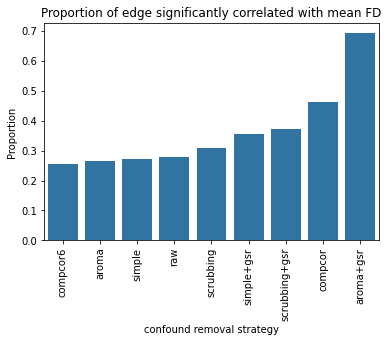

In [2]:
bar_color = sns.color_palette()[0]
order = (sig_per_edge<0.05).mean().sort_values().index.tolist()
ax = sns.barplot(data=(sig_per_edge<0.05), ci=None, order=order, color=bar_color)
ax.set_title("Proportion of edge significantly correlated with mean FD")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Proportion",
       xlabel="confound removal strategy")

Text(0.5, 0.98, 'Distribution of correlation between framewise distplacement and edge strength')

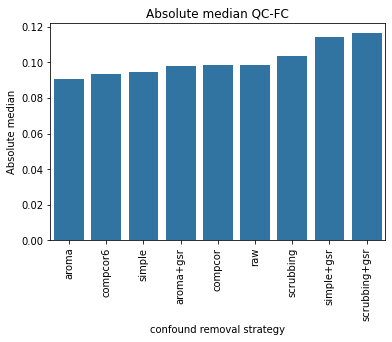

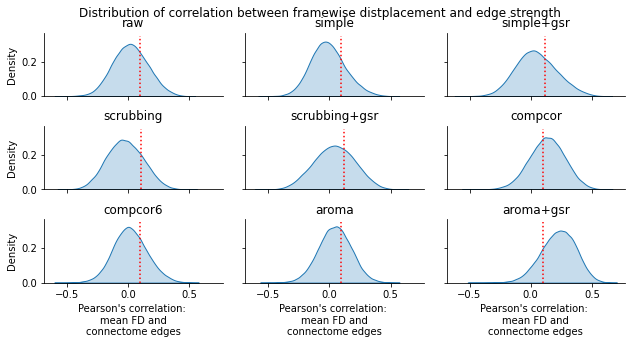

In [7]:
def calculate_mad(x):
    return (x - x.median()).abs().median()

mad = metric_per_edge.apply(calculate_mad)
order = mad.sort_values().index.tolist()

ax = sns.barplot(data=(pd.DataFrame(mad).T), ci=None, order=order, color=bar_color)
ax.set_title("Absolute median QC-FC")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Absolute median",
       xlabel="confound removal strategy")


def draw_absolute_median(data, **kws):
    ax = plt.gca()
    mad = calculate_mad(data['qcfc'])
    ax.vlines(mad, ymin=0, ymax=0.35, color='r', linestyle=':')
    
g = sns.displot(
    long_qcfc, x="qcfc", col="col", row="row", kind='kde', fill=True, height=1.5, aspect=2
)
g.set(ylabel="Density")
g.map_dataframe(draw_absolute_median)
for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)
    if axis_i == 2:
        g.facet_axis(axis_i, axis_j).set(xlabel="Pearson\'s correlation: \nmean FD and\nconnectome edges")
        
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Distribution of correlation between framewise distplacement and edge strength')

Text(0.5, 0.98, 'Correlation between nodewise Euclidian distance and QCFC')

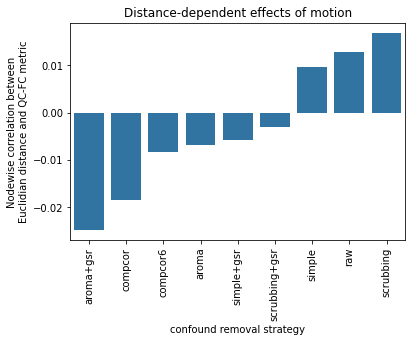

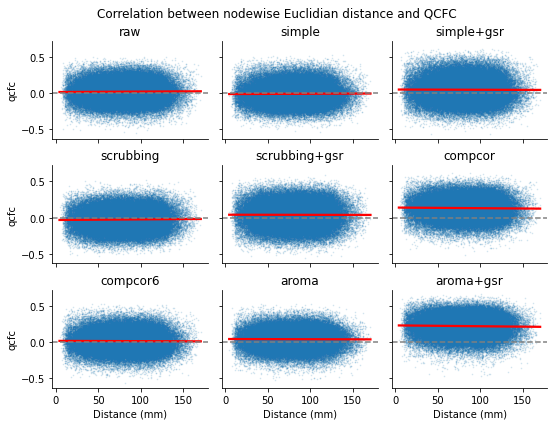

In [10]:
corr_distance = np.corrcoef(pairwise_distance.iloc[:, -1], metric_per_edge.T)[1:, 0]
corr_distance = pd.DataFrame(corr_distance, index=z_metric_per_edge.columns)
long_qcfc['distance'] = np.tile(pairwise_distance.iloc[:, -1].values, 9)

order = corr_distance.sort_values(0).index.tolist()

ax = sns.barplot(data=corr_distance.T, ci=None, order=order, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Distance-dependent effects of motion")
ax.set(ylabel="Nodewise correlation between\nEuclidian distance and QC-FC metric",
        xlabel="confound removal strategy")

g = sns.FacetGrid(long_qcfc, col="col", row="row", height=2, aspect=1.3)
g.map(sns.regplot, 'distance', 'qcfc', fit_reg=True, ci=None, 
      line_kws={'color': 'red'}, scatter_kws={'s': 0.5, 'alpha': 0.15,})
g.refline(y=0)
for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)
    if axis_i == 2:
        g.facet_axis(axis_i, axis_j).set(xlabel="Distance (mm)")
        
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Correlation between nodewise Euclidian distance and QCFC')

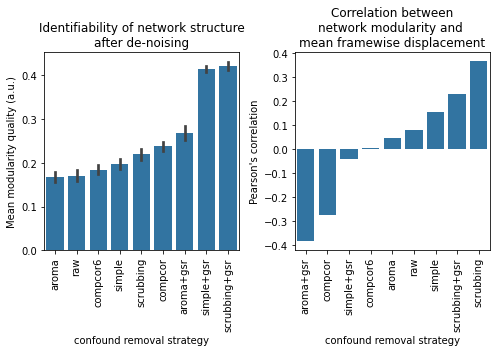

In [6]:
corr_modularity = []
z_movment = movement.apply(zscore)
for column, values in modularity.iteritems():
    current_strategy = partial_correlation(values.values, 
                                           z_movment['mean_framewise_displacement'].values, 
                                           z_movment[['Age', 'Gender']].values)
    current_strategy['strategy'] = column
    corr_modularity.append(current_strategy)

plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
order = modularity.mean().sort_values().index.tolist()
ax = sns.barplot(data=modularity, order=order, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Identifiability of network structure\nafter de-noising")
ax.set(ylabel="Mean modularity quality (a.u.)",
       xlabel="confound removal strategy")
plt.subplot(1, 2, 2)

corr_modularity = pd.DataFrame(corr_modularity).sort_values('correlation')
ax = sns.barplot(data=corr_modularity, y='correlation', x='strategy', ci=None, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Correlation between\nnetwork modularity and \nmean framewise displacement")
ax.set(ylabel="Pearson's correlation",
       xlabel="confound removal strategy")
plt.tight_layout()

### Conclusions

The denosing methods involving global signal regreesion is systematically contradicting with the literature {cite:p}`ciric_benchmarking_2017` {cite:p}`parkes_evaluation_2018`. 
Further investigation is needed.
We will to run the same benchmark on different fMRIPrepLTS outputs and different type of parcelation scheme.
The aim is to provide a software for researchers to produce the benchmark for their own dataset to select the most suitable strategy.

### References
```{bibliography}
:filter: docname in docnames
```